In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
block_size = 3
X, Y = [],[]
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + ".":
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
C = torch.randn((27, 2))

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.rand(100)

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [ ]:
# torch.cat(torch.unbind(emb, 1), 1)

In [ ]:
# emb.view(32, 6)

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

tensor([[ 0.8655, -0.9997, -1.0000,  ...,  0.9998,  0.9773,  0.9998],
        [-0.9740, -0.9998, -1.0000,  ...,  0.9479,  0.8058,  0.9999],
        [-0.2529, -0.8803, -0.9903,  ..., -0.7604, -0.9854,  0.9999],
        ...,
        [-0.9899, -0.9925, -0.9745,  ..., -0.9040, -0.8407,  0.9988],
        [ 0.9971,  0.9150,  0.1802,  ...,  0.9920,  0.9896,  0.9760],
        [-0.9849, -0.6442, -0.9429,  ...,  0.2698,  0.3302, -0.4356]])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.rand(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([228146, 27])

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
loss = -probs[torch.arange(32), Y].log().mean()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
loss

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.rand(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

3481

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
# lri = []
# lossi = []
for i in range(10000):
  # construct mini-batch
  ix = torch.randint(0, X.shape[0], (32,))
  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  lr = 0.01 # lrs[i]
  for p in parameters:
    p.data += -lr * p.grad
    
  # track stats
  # lri.append(lr)
  # lossi.append(loss.item())

print(loss.item())

2.3196334838867188


In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5652, grad_fn=<NllLossBackward0>)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
def build_dataset(words):
  block_size = 3
  X, Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n1, n2

(25626, 28829)

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.rand(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
stepi = []
lossi = []

In [ ]:
for i in range(200000):
  # construct mini-batch
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  lr = 0.1 if i < 100000 else 0.01 # lrs[i]
  for p in parameters:
    p.data += -lr * p.grad
    
  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.8761777877807617


[<matplotlib.lines.Line2D>]

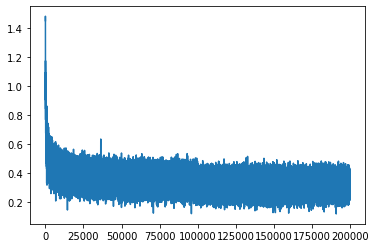

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1158, grad_fn=<NllLossBackward0>)

In [ ]:
# eval
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1634, grad_fn=<NllLossBackward0>)

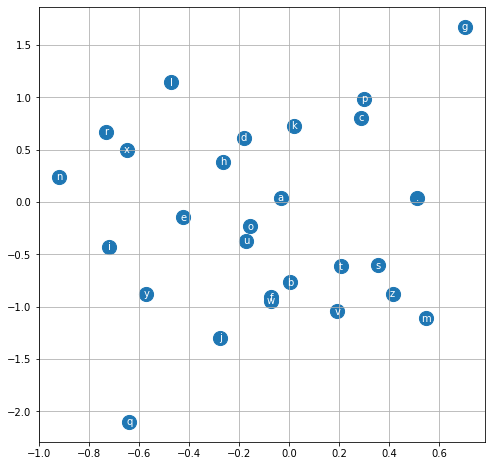

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

carmahela.
jharlin.
mili.
taty.
salaysleer.
hunn.
dellahti.
geric.
romari.
chaiir.
kaleigh.
ham.
jorn.
quint.
sulin.
alvin.
quince.
ogderrini.
jaxen.
dus.
